## Continuation of Image Analysis + Matched Filtering

In the last lesson we talked about image analysis segmentation (hopefully you have an image of your disemboddied face somewhere now!) In this lesson we will continue with this theme, as well as discuss how one might go about using this to analyze a realistic Image.

First, some imports, plus a handy function to make it easier to visualize our sample data.

In [151]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

Populating the interactive namespace from numpy and matplotlib


Here is an image that comes standard in a dataset for scikit-image. Since this isn't a standard package and I just have it as an image file here.

In [31]:
import matplotlib.image as mpimg

img = mpimg.imread('./paper.png') 

img = img[:,:,:3].sum(axis=2)

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114235b50>)

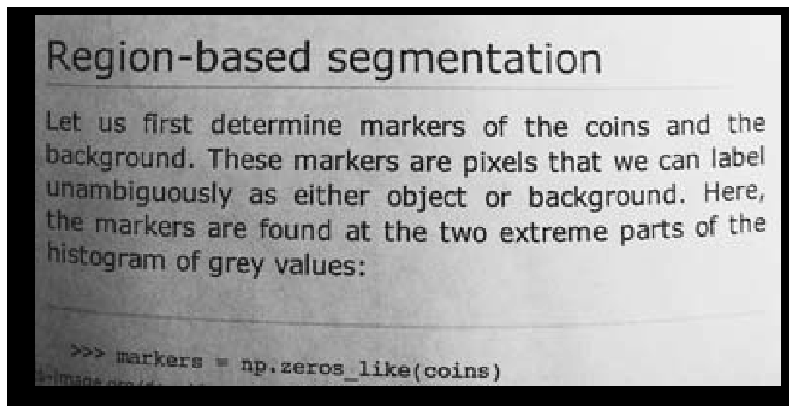

In [32]:
image_show(img)

Notice that there is a gradient of shadow across the image. This will make it difficult to define a clear threasholding, as you'll see below.

First we will look at the pixel color values to see if there is a seperation between letters and non-letters...

(array([51092.,   768.,  1653.,  3185.,  4030.,  4677.,  4273.,  4248.,
         4141.,  5938.,  6948.,  8714.,  8638.,  8718.,  8922., 11414.,
        13845., 17780., 14862., 15125., 18342., 18555., 16117., 16738.,
        14911., 15474., 25550., 25101., 50356., 42564.,  3679.,  1050.]),
 array([0.     , 0.09375, 0.1875 , 0.28125, 0.375  , 0.46875, 0.5625 ,
        0.65625, 0.75   , 0.84375, 0.9375 , 1.03125, 1.125  , 1.21875,
        1.3125 , 1.40625, 1.5    , 1.59375, 1.6875 , 1.78125, 1.875  ,
        1.96875, 2.0625 , 2.15625, 2.25   , 2.34375, 2.4375 , 2.53125,
        2.625  , 2.71875, 2.8125 , 2.90625, 3.     ], dtype=float32),
 <a list of 32 Patch objects>)

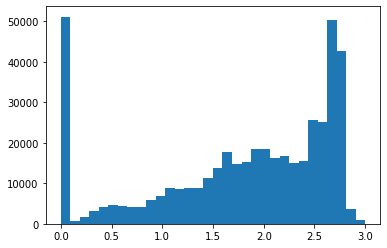

In [152]:
fig, ax = plt.subplots(1, 1)
ax.hist(img.ravel(), bins=32)


On the surface this might look promising... Maybe all the letters are clustered on either extreme of the distribution and we can use a simple threshholding!

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122853750>)

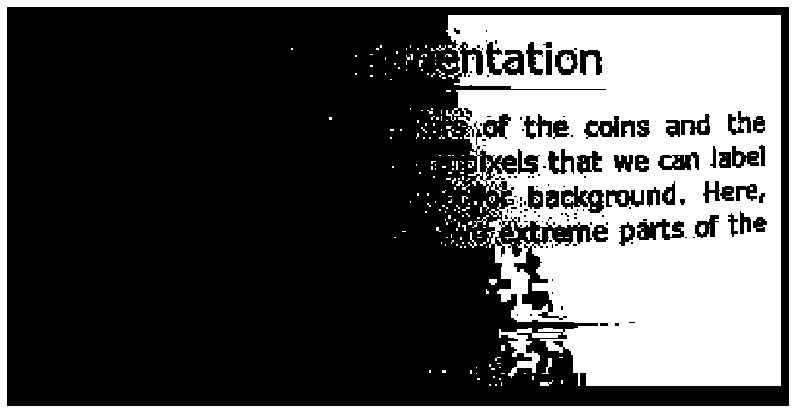

In [154]:
text_segmented = img > 2.50#(try other values here if you want!)
image_show(text_segmented)

Nope! Our "noise" (the shadow) is highly variable accross the field :'( 

Lets try something a bit smarter! Since the text composes small portion of the overall image, we can create a good estimate of what the image looks like without the text (i.e. the shadow property) by smoothing the field, and subtracting off that smoothed field!

This is actually similar to something astronomers do when they take observations. Since the properties of the detectors in the telescope are highly variable, it is useful to take a picture of what the night sky would look like without the stars in order to calibrate the chips. Fortunately in the case of telescopes one can just close the telescopes dome and take pictures of the (hopefully completely dark) interior dome surface. These are known as "dome flats."

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122853190>)

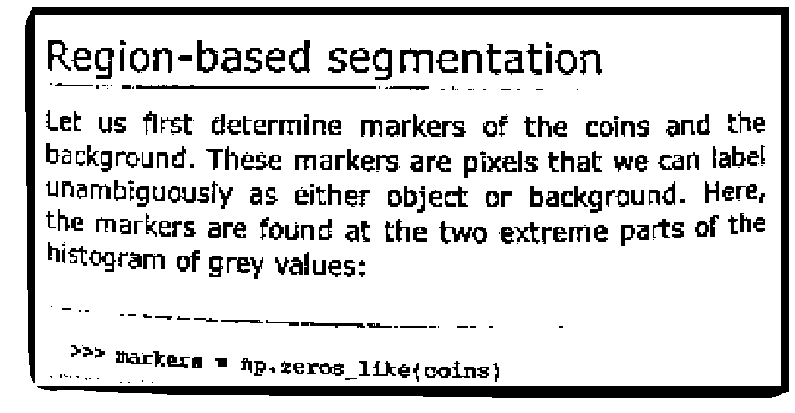

In [155]:
from scipy import ndimage
new_image = img-ndimage.gaussian_filter(img,10)

text_segmented = new_image > -0.20
# (I played with this value till I got a picture I liked... one could probably find it algorithmically too)
image_show(text_segmented)


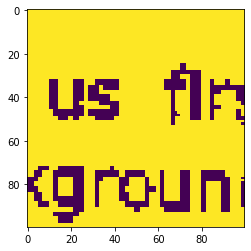

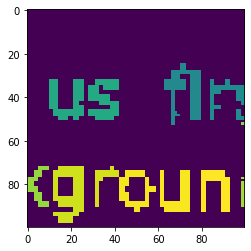

In [156]:
#Using the segmentation algorithm from before
label_im,nb_labels = ndimage.label(ndimage.gaussian_filter(1-text_segmented,0.1))
imshow(text_segmented[100:200,100:200])
plt.show()
imshow(label_im[100:200,100:200])
plt.show()


Hurray! Our letters seem seperated! Maybe a few are still "stuck" together... Would probably need some strong prior on what a "letter" is in order to have 100% proper seperation.

0 444


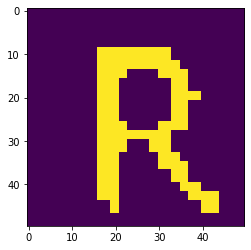

1 453


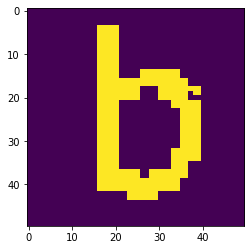

2 458


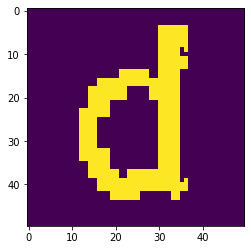

3 282


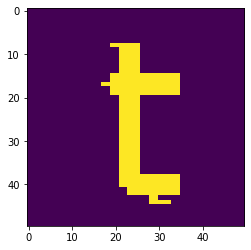

4 294


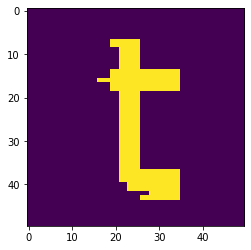

5 315


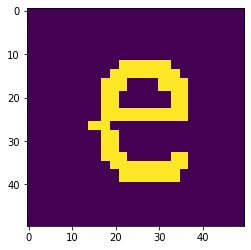

6 459


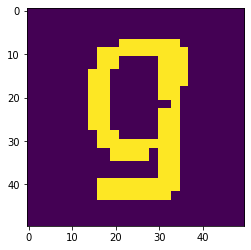

7 134


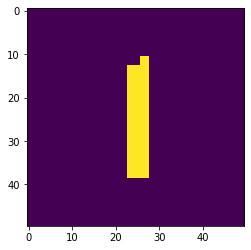

8 332


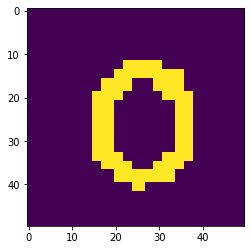

9 372


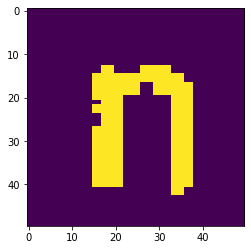

10 395


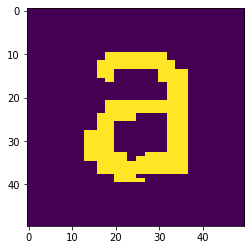

11 324


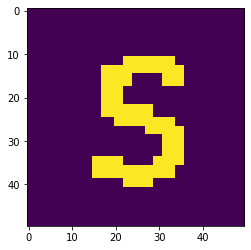

12 384


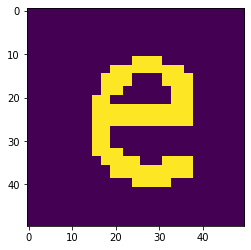

13 334


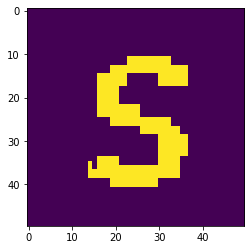

14 387


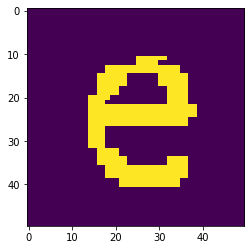

15 471


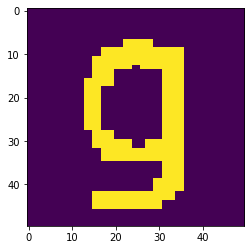

16 373


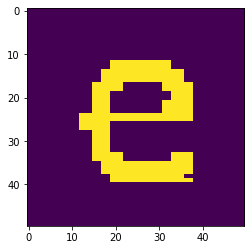

17 376


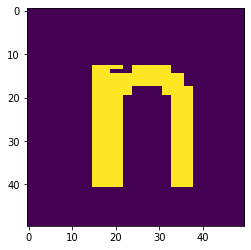

18 389


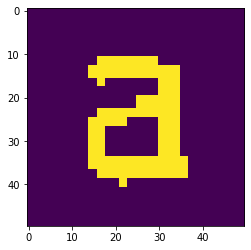

19 186


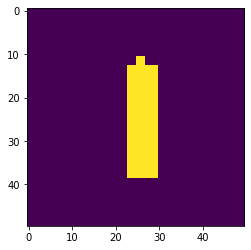

20 343


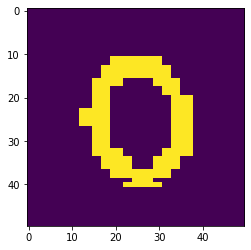

21 339


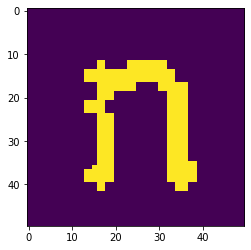

22 104


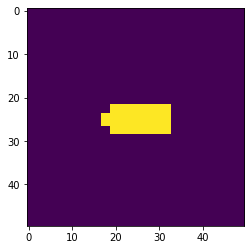

23 102


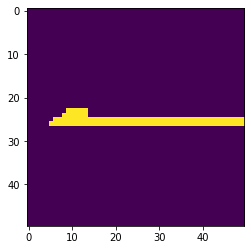

24 55


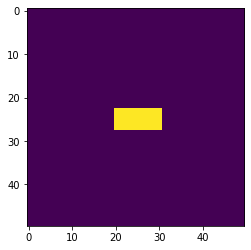

25 159


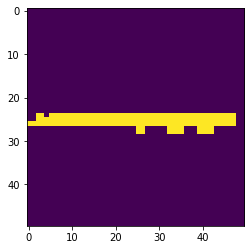

In [167]:
#iterate and save letters
output = []
counter = 0
for i in range(0,50):
    image_cut = label_im==i
    if sum(image_cut)>50 and sum(image_cut)<500: #just to throw out some non-letter features of the image
        print(counter,sum(image_cut))
        x,y = np.array(ndimage.center_of_mass(image_cut)).astype(int) #find center of each letter
    #print(x,y)
        imshow(image_cut[x-25:x+25,y-25:y+25]) #display letter
        output.append(image_cut[x-25:x+25,y-25:y+25]) #save "postage stamp"
        counter += 1 
        plt.show()

Yay, our letters look very letter-like! This sort of process would probably be a bit harder for 漢字 which have many disconnected radicals. For the latin alphabet in normal type the only disconnected character is a lowercase "i", which is still generally recognizable without the dot.

Let now try and figure out a simple filter in order to have a computer recognize the characters. There are many ways to do this (turing the characters into graphs, using their topological properties, etc.), but we will do perhaps the "simplest" method and use a matched filter. This will work very well if the characters are the same size.

The idea of a matched filter is we have a template of what we think the letters should look like, which in this case will be a boolean array. We then multiply it pixel by pixel on a given test image. If the pixels match, they will be "true" otherwise false. One then sums the true elements to get a final figure.

template image 315


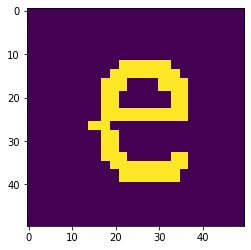

test image : 384


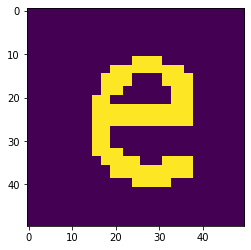

test image * template :  268


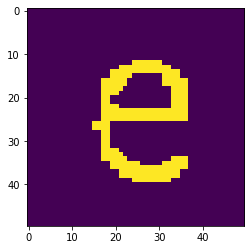

In [168]:
#Example
print("template image", np.sum(output[5]))
imshow(output[5])
plt.show()
print("test image :", np.sum(output[12]))
imshow(output[12])
plt.show()

print("test image * template : ",np.sum(output[12]*output[5]))
imshow(output[12]*output[5])
plt.show()


0 184
1 203
2 164
3 126
4 142
5 315


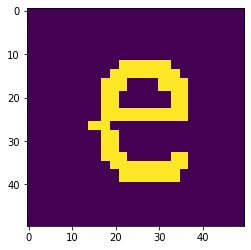

6 152
7 52
8 234
9 195
10 223
11 198
12 268


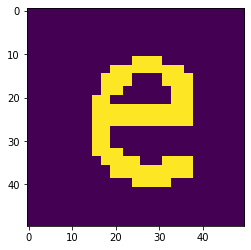

13 195
14 264


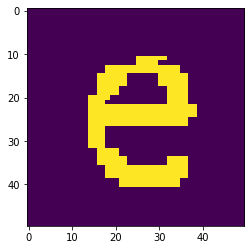

15 146
16 278


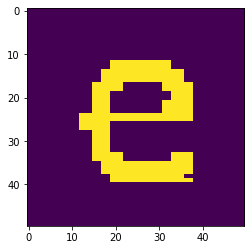

17 199
18 218
19 72
20 205
21 186
22 52
23 25
24 33
25 45


In [169]:
#iterate over some characters. If there is high overlap, show image, otherwise don't show

filt = output[5]

for n,i in enumerate(output):
    print(n,np.sum(filt*i))
    if np.sum(filt*i)>260: #value set arbitrarily... 
        imshow(i)
        plt.show()

You can probably think of lots of cases this technique would fail, to list some of the cases:

1) Images slightly different sizes

2) Center of Mass not well found (maybe due to an artifact)

3) Images rotated

4) "Blended" images of multiple letters together

5) etc...

One could of course create algorithms to get around these issues. Maybe one moves the filter around and dilates it to try and find a match in each image. Also, in this implementation we don't penalize if the test image has too many true values, so a solid true rectangle would match any letter, so we might want a more percise cost function.

## Introduction to Clustering Algorithms

In the above example, we might eventually want to make the jump to algorithmically grouping together letters into each letter class (i.e. "a","A","b","B", ...) We do not apriori know which letter is which so we don't have a "training" set like we did in our neighbors analysis last week. This is an example of "unsupervised learning." 

To begin with, we will go over clustering algorithms which group together like classes based on their closeness in feature space.

For an overview of clustering algorithms, take a look at the [sklearn documentation](https://scikit-learn.org/stable/modules/clustering.html).

### K-means

This is probably the most common clustering algorithm. 

"The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields."

$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$

Essentially we want each cluster to have as small of variance as possible. Algorithmically we start by choosing $k$ random points as the begining centers. We slowly add nearby points, moving the centers as we progress.

See animation here: https://www.youtube.com/watch?v=BVFG7fd1H30

Populating the interactive namespace from numpy and matplotlib


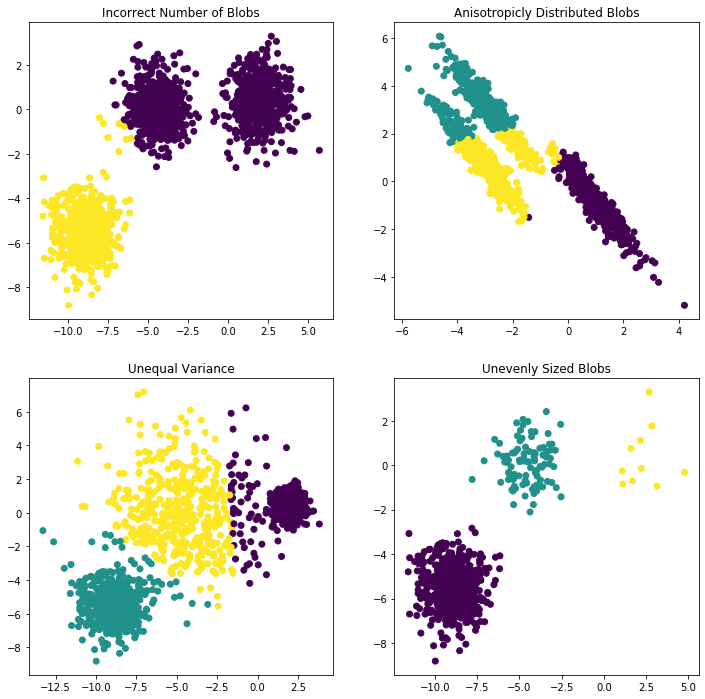

In [2]:
%pylab inline
# Author: Phil Roth <mr.phil.roth@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()


### Gaussian Mixture Model

Here, we assume each cluster should look vaguely like a multivariate Gaussian.

"A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians."

Abstractly, all we are doing is fitting the centers and covariance (the shape) of each gaussian in our model, with a certain loss function. 

Automatically created module for IPython interactive environment


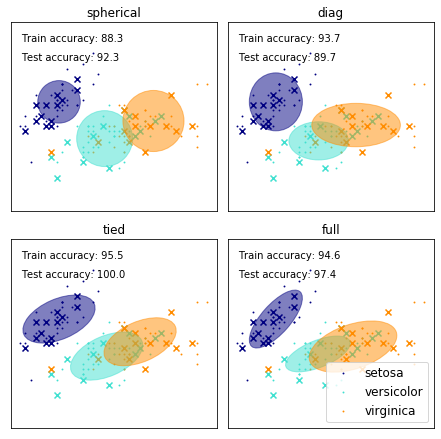

In [3]:
#example from website

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()
